In [ ]:
!pip install scikit-fuzzy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 11.4 MB/s eta 0:00:00


# Fuzzification - initialisation of variables

In [ ]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

proximity = ctrl.Antecedent(np.arange(0, 31, 100), 'proximity')
severity = ctrl.Antecedent(np.arange(0, 3.1, 0.01), 'severity')
shielding = ctrl.Antecedent(np.arange(0, 1.01, 0.01), 'shielding')

effect = ctrl.Consequent(np.arange(0, 101, 1), 'effect')
effect['low'] = fuzz.trimf(effect.universe, [0, 0, 50])
effect['medium'] = fuzz.trimf(effect.universe, [25, 50, 75])
effect['high'] = fuzz.trimf(effect.universe, [50, 100, 100])

In [ ]:
input_cyclone_lat = 17.7
input_cyclone_lon = 83.3

# Proximity (P)

Dynamically generating fuzzy sets based on actual proximity distances— it makes our system more adaptable to different cyclone scenarios. Here's how we can break it down and implement it:

csv file of the geographical coordinates of the cities localities is known data

In [ ]:
from math import radians, cos, sin, asin, sqrt
import pandas as pd

def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*sin(dlon/2)**2
    c = 2*asin(sqrt(a))
    return R * c

df = pd.read_csv("localities.csv")

cyclone_lat = input_cyclone_lat
cyclone_lon = input_cyclone_lon

df["Distance_km"] = df.apply(
    lambda row: haversine(cyclone_lat, cyclone_lon, row["lat"], row["lon"]), axis=1
)
df["Distance_km"].describe()

,Distance_km
count,137.000000
mean,10.387091
std,5.534179
min,0.556149
25%,6.966488
50%,10.267656
75%,13.706906
max,29.473240


In [ ]:
min_d = df["Distance_km"].min()
max_d = df["Distance_km"].max()
avg_d = df["Distance_km"].mean()

low_range = [min_d, min_d + (avg_d - min_d)/2, avg_d]
medium_range = [min_d + (avg_d - min_d)/2, avg_d, avg_d + (max_d - avg_d)/2]
high_range = [avg_d, avg_d + (max_d - avg_d)/2, max_d]

In [ ]:
low_range, medium_range, high_range

([0.5561488263616184,
  np.float64(5.471619905147685),
  np.float64(10.387090983933751)],
 [np.float64(5.471619905147685),
  np.float64(10.387090983933751),
  np.float64(19.93016559880577)],
 [np.float64(10.387090983933751),
  np.float64(19.93016559880577),
  29.473240213677794])

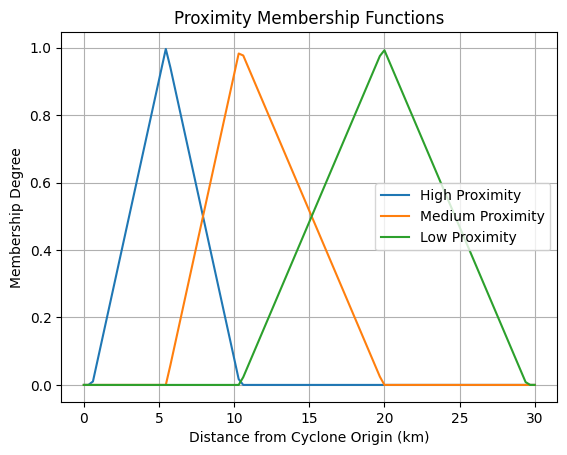

In [ ]:
import numpy as np
import skfuzzy as fuzz
import matplotlib.pyplot as plt

x = np.linspace(0, 30, 100)
proximity = ctrl.Antecedent(x, 'proximity')

proximity["low"] = fuzz.trimf(x, low_range)
proximity["medium"] = fuzz.trimf(x, medium_range)
proximity["high"] = fuzz.trimf(x, high_range)

plt.plot(x, proximity["low"].mf, label='High Proximity')
plt.plot(x, proximity["medium"].mf, label='Medium Proximity')
plt.plot(x, proximity["high"].mf, label='Low Proximity')
plt.title("Proximity Membership Functions")
plt.xlabel("Distance from Cyclone Origin (km)")
plt.ylabel("Membership Degree")
plt.legend()
plt.grid(True)
plt.show()


# Severity (S)

based on historic data, our model will predict the severity of the cyclone given its origin coordinates

In [ ]:
!pip install beautifulsoup4

In [ ]:
# # data extraction and cleaning
# from bs4 import BeautifulSoup
# import csv

# with open('Cyclone_data.html', 'r', encoding='utf-8') as file:
#   html_data = file.read()

# soup = BeautifulSoup(html_data, 'html.parser')

# tables = soup.find_all('table')

# csv_filename = "cyclone_data.csv"
# with open(csv_filename, 'w', newline='') as csvfile:
#     csvwriter = csv.writer(csvfile)

#     headers = ['Month', 'Sl.No.', 'Year', 'Max Intensity', 'Initial Date', 'Lat(°N)', 'Lon(°E)']
#     csvwriter.writerow(headers)

#     for table in tables:
#         month_header = table.find_previous_sibling('tr')
#         if month_header and 'Month of' in month_header.text:
#             month = month_header.text.strip().replace('Month of ', '')
#         else:
#             month = "Unknown"

#         rows = table.find_all('tr')

#         for row in rows[1:]:
#             cells = row.find_all('td')
#             if cells:
#                 sl_no = ""
#                 year = ""
#                 max_intensity = ""
#                 initial_date = ""
#                 lat = ""
#                 lon = ""

#                 # Extract data from cells
#                 if len(cells) >= 1:
#                     sl_no = cells[0].text.strip()
#                 if len(cells) >= 2:
#                     year = cells[1].text.strip()
#                 if len(cells) >= 3:
#                     max_intensity = cells[2].text.strip()
#                 if len(cells) >= 4:
#                     initial_date = cells[3].text.strip()
#                 lat = cells[4].text.strip()
#                 lon = cells[5].text.strip()

#                 # Construct the row data with default values for missing data
#                 row_data = [
#                     month,
#                     sl_no,
#                     year,
#                     max_intensity,
#                     initial_date,
#                     lat,
#                     lon
#                 ]
#                 csvwriter.writerow(row_data)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime as now


def load_cyclone_data(file_path):
    df = pd.read_csv(file_path)
    df = df[['Year', 'Max Intensity', 'Initial Date', 'Month', 'Lat' , "Lon"]]
    intensity_map = {'D': 1, 'CS': 2, 'SCS': 3}
    df['Intensity'] = df['Max Intensity'].map(intensity_map)
    df['Season'] = np.where(df['Month'].isin([3,4,5]), 'Summer',
                            np.where(df['Month'].isin([12,1,2]), 'Winter', 'Monsoon'))
    df = pd.get_dummies(df, columns=['Season'], prefix='Season')
    return df

file_path = 'cyclone_data.csv'
df = load_cyclone_data(file_path)


param_grid = {
    'n_estimators': [250, 275, 200],
    'max_depth': [4, 5],
    'min_samples_split': [10, 6],
    'min_samples_leaf': [3, 2, 4],
    'max_features': ['sqrt']
}

features = df[['Lat', 'Lon', 'Month', 'Season_Monsoon', 'Season_Summer', 'Season_Winter']]
target = df['Intensity']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2)

model = RandomForestRegressor(random_state=42)

model.fit(X_train, y_train)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

y_pred = best_model.predict(X_test)
print("MSE:", mean_squared_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

model = best_model

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 6, 'n_estimators': 275}
MSE: 0.4400213226969215
R² Score: 0.2829207046863841


In [ ]:
month = now.now().month
monsoon = 1 if month in [6,7,8,9,10,11] else 0
summer = 1 if month in [3,4,5] else 0
winter = 1 if month in [12,1,2] else 0
pred_score = model.predict([[input_cyclone_lat, input_cyclone_lon, month, monsoon, summer, winter]])
print("Predicted Severity Score:", pred_score)

Predicted Severity Score: [1.82009865]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


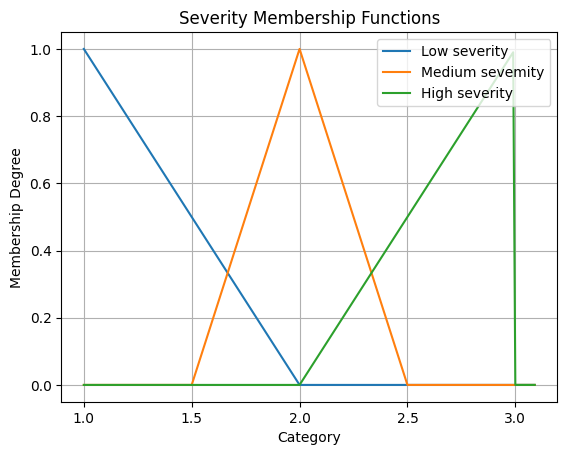

Fuzzy Severity:
Low: 0.18, Medium: 0.64, High: 0.00


In [ ]:
import skfuzzy as fuzz
import numpy as np

x_severity = np.arange(1, 3.1, 0.01)
severity = ctrl.Antecedent(x_severity, 'severity')

severity['low'] = fuzz.trimf(x_severity, [1.0, 1.0, 2.0])
severity['medium'] = fuzz.trimf(x_severity, [1.5, 2.0, 2.5])
severity['high'] = fuzz.trimf(x_severity, [2.0, 3.0, 3.0])

plt.plot(x_severity, severity['low'].mf, label='Low severity')
plt.plot(x_severity, severity['medium'].mf, label='Medium sevemity')
plt.plot(x_severity, severity['high'].mf, label='High severity')
plt.title("Severity Membership Functions")
plt.xlabel("Category")
plt.ylabel("Membership Degree")
plt.legend()
plt.grid()
plt.show()

pred = pred_score[0]
low_degree = fuzz.interp_membership(x_severity, severity['low'].mf, pred)
med_degree = fuzz.interp_membership(x_severity, severity['medium'].mf, pred)
high_degree = fuzz.interp_membership(x_severity,severity['high'].mf, pred)

print(f"Fuzzy Severity:\nLow: {low_degree:.2f}, Medium: {med_degree:.2f}, High: {high_degree:.2f}")


# Shielding (G)

Bearing & Directional shielding --based on input cyclone origin

In [ ]:
import math

def calculate_bearing(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    delta_lon = lon2 - lon1
    x = math.sin(delta_lon) * math.cos(lat2)
    y = math.cos(lat1)*math.sin(lat2) - (math.sin(lat1)*math.cos(lat2)*math.cos(delta_lon))
    initial_bearing = math.atan2(x, y)
    bearing = math.degrees(initial_bearing)
    return (bearing + 360) % 360


def elevation_membership(elev):
    if elev <= 10:
        return (1.0, 0.0, 0.0)
    elif elev <= 40:
        low = (40 - elev) / 30
        med = (elev - 10) / 30
        return (low, med, 0.0)
    elif elev <= 70:
        med = (70 - elev) / 30
        high = (elev - 40) / 30
        return (0.0, med, high)
    else:
        return (0.0, 0.0, 1.0)

def directional_membership(bearing):
    if bearing <= 30 or bearing >= 330:
        return (1.0, 0.0, 0.0)
    elif bearing <= 60:
        shield = (60 - bearing) / 30
        moderate = (bearing - 30) / 30
        return (shield, moderate, 0.0)
    elif bearing <= 120:
        moderate = (120 - bearing) / 60
        exposed = (bearing - 60) / 60
        return (0.0, moderate, exposed)
    elif bearing <= 240:
        return (0.0, 0.0, 1.0)
    elif bearing <= 300:
        exposed = (300 - bearing) / 60
        moderate = (bearing - 240) / 60
        return (0.0, moderate, exposed)
    elif bearing <= 330:
        moderate = (330 - bearing) / 30
        shield = (bearing - 300) / 30
        return (shield, moderate, 0.0)


def combined_shielding_score(elev, bearing, w_elev=0.4, w_dir=0.6):
    elev_membership = elevation_membership(elev)
    dir_membership = directional_membership(bearing)

    combined = tuple(round(w_elev * e + w_dir * d, 2) for e, d in zip(elev_membership, dir_membership))
    return {
        "Low Shielding": combined[0],
        "Medium Shielding": combined[1],
        "High Shielding": combined[2]
    }

In [ ]:
df2 = pd.read_csv("localities_with_elevation.csv")
results = []
for _, loc in df2.iterrows():
    elevation = loc['Elevation']
    bearing = calculate_bearing(input_cyclone_lat, input_cyclone_lon, loc["lat"], loc["lon"])
    shielding_score = combined_shielding_score(elevation, bearing)

    results.append({
        "Area": loc["name"],
        "Latitude": loc["lat"],
        "Longitude": loc["lon"],
        "Elevation (m)": elevation,
        "Bearing (°)": round(bearing, 2),
        "Combined Shielding Score": shielding_score
    })

pd.DataFrame(results)
shielding_df = pd.DataFrame(results)
shielding_df

,Area,Latitude,Longitude,Elevation (m),Bearing (°),Combined Shielding Score
0,Rushikonda,17.793070,83.384867,21.0,40.96,"{'Low Shielding': 0.63, 'Medium Shielding': 0...."
1,Ukkunagaram Township,17.655109,83.148651,31.0,252.73,"{'Low Shielding': 0.12, 'Medium Shielding': 0...."
2,Simhachalam,17.772629,83.243349,71.0,323.40,"{'Low Shielding': 0.47, 'Medium Shielding': 0...."
3,Childrens Theatre,17.720553,83.319205,55.0,41.67,"{'Low Shielding': 0.37, 'Medium Shielding': 0...."
4,Chrome,17.719968,83.319682,55.0,43.19,"{'Low Shielding': 0.34, 'Medium Shielding': 0...."
...,...,...,...,...,...,...
132,Akkayyapalem,17.738186,83.299155,35.0,358.79,"{'Low Shielding': 0.67, 'Medium Shielding': 0...."
133,Andhra Kesari Nagar,17.744843,83.245017,49.0,310.58,"{'Low Shielding': 0.21, 'Medium Shielding': 0...."
134,Netaji Colony,17.745878,83.240779,39.0,309.13,"{'Low Shielding': 0.2, 'Medium Shielding': 0.8..."
135,Madhavadhara,17.747455,83.259291,51.0,320.75,"{'Low Shielding': 0.42, 'Medium Shielding': 0...."


In [ ]:
# shielding['low'] = fuzz.trimf(shielding.universe, [0, 0, 0.5])
# shielding['medium'] = fuzz.trimf(shielding.universe, [0.3, 0.5, 0.7])
# shielding['high'] = fuzz.trimf(shielding.universe, [0.5, 1, 1])

# Fuzzification - output computation

In [ ]:
def inference_engine(prox_val, sev_val, shielding_tuple):
    μ_prox_low = fuzz.interp_membership(proximity.universe, proximity['low'].mf, prox_val)
    μ_prox_med = fuzz.interp_membership(proximity.universe, proximity['medium'].mf, prox_val)
    μ_prox_high = fuzz.interp_membership(proximity.universe, proximity['high'].mf, prox_val)

    μ_sev_low = fuzz.interp_membership(severity.universe, severity['low'].mf, sev_val)
    μ_sev_med = fuzz.interp_membership(severity.universe, severity['medium'].mf, sev_val)
    μ_sev_high = fuzz.interp_membership(severity.universe, severity['high'].mf, sev_val)

    μ_shield_low, μ_shield_med, μ_shield_high = shielding_tuple

    # rules (x27)
    rules = []

    levels = ['low', 'medium', 'high']
    μ_prox = {'low': μ_prox_high, 'medium': μ_prox_med, 'high': μ_prox_low}
    μ_sev = {'low': μ_sev_low, 'medium': μ_sev_med, 'high': μ_sev_high}
    μ_shield = {'low': μ_shield_low, 'medium': μ_shield_med, 'high': μ_shield_high}

    for p in levels:
        for s in levels:
            for sh in levels:
                if p == 'high' and s == 'high' and sh == 'low':
                    label = 'high'
                elif s == 'low' and sh == 'high':
                    label = 'low'
                elif s == 'high' and p != 'low':
                    label = 'high'
                elif s == 'medium' and p == 'medium':
                    label = 'medium'
                else:
                    label = 'medium'

                strength = min(μ_prox[p], μ_sev[s], μ_shield[sh])
                rules.append((strength, label))


    agg_output = np.zeros_like(effect.universe)

    for strength, label in rules:
        mf = fuzz.interp_membership(effect.universe, effect[label].mf, effect.universe)
        clipped = np.fmin(strength, mf)
        agg_output = np.fmax(agg_output, clipped)

    # defuzzification
    final_effect = fuzz.defuzz(effect.universe, agg_output, 'centroid')
    return final_effect


In [ ]:
prox_val = 8
sev_val = pred_score[0]
shielding_tuple = (0.2, 0.1, 0.2)

effect_res = inference_engine(prox_val, sev_val, shielding_tuple)
print(effect_res)

37.18154402779774


In [ ]:
localities_df = pd.read_csv("localities_with_elevation.csv")

month = now.now().month
monsoon = 1 if month in [6,7,8,9,10,11] else 0
summer = 1 if month in [3,4,5] else 0
winter = 1 if month in [12,1,2] else 0
sev_val = model.predict([[input_cyclone_lat, input_cyclone_lon, month, monsoon, summer, winter]])[0]
print("Predicted cyclone severity: ", sev_val)

effect_df = []
for _, loc in localities_df.iterrows():

    prox_val = haversine(loc['lat'], loc['lon'], input_cyclone_lat, input_cyclone_lon)

    elevation = loc['Elevation']
    bearing = calculate_bearing(input_cyclone_lat, input_cyclone_lon, loc["lat"], loc["lon"])
    shielding_tuple = tuple(combined_shielding_score(elevation, bearing).values())

    result = inference_engine(prox_val, sev_val, shielding_tuple)
    effect_df.append({
        "Area": loc["name"],
        "Latitude": loc["lat"],
        "Longitude": loc["lon"],
        "Elevation (m)": elevation,
        "Bearing (°)": round(bearing, 2),
        "Proximity": prox_val,
        "Effect": result
    })

effect_df = pd.DataFrame(effect_df)
effect_df

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Predicted cyclone severity:  1.820098652748182


,Area,Latitude,Longitude,Elevation (m),Bearing (°),Proximity,Effect
0,Rushikonda,17.793070,83.384867,21.0,40.96,13.706906,50.000000
1,Ukkunagaram Township,17.655109,83.148651,31.0,252.73,16.793596,42.207601
2,Simhachalam,17.772629,83.243349,71.0,323.40,10.060852,42.207601
3,Childrens Theatre,17.720553,83.319205,55.0,41.67,3.059617,41.813993
4,Chrome,17.719968,83.319682,55.0,43.19,3.045711,42.114535
...,...,...,...,...,...,...,...
132,Akkayyapalem,17.738186,83.299155,35.0,358.79,4.247044,50.000000
133,Andhra Kesari Nagar,17.744843,83.245017,49.0,310.58,7.666735,44.962229
134,Netaji Colony,17.745878,83.240779,39.0,309.13,8.085193,50.000000
135,Madhavadhara,17.747455,83.259291,51.0,320.75,6.814353,43.046237


In [ ]:
import folium
from folium.plugins import HeatMap
import branca.colormap as cm
import pandas as pd

df = pd.DataFrame(effect_df)
df['Effect_norm'] = (df['Effect'] - df['Effect'].min()) / (df['Effect'].max() - df['Effect'].min())

map_center = [17.6868, 83.2185]

m = folium.Map(
    location=map_center,
    zoom_start=12,
    min_zoom=11,
    max_zoom=16,
    width='60%',
    height='500px'
)

m.fit_bounds([[17.5, 82.9], [17.85, 83.35]])

folium.Marker(
    [input_cyclone_lat, input_cyclone_lon],
    popup='Cyclone Origin',
    icon=folium.Icon(color='red', icon='info-sign')
).add_to(m)

min_effect = df["Effect"].min()
max_effect = df["Effect"].max()
colormap = cm.LinearColormap(colors=["green", "yellow", "red"],
                             vmin=min_effect, vmax=max_effect,
                             caption='Cyclone Effect Intensity')
colormap.add_to(m)

for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=6,
        weight=1,
        fill=True,
        fill_opacity=0.8,
        fill_color=colormap(row['Effect']),
        color='black',
        popup=folium.Popup(f"{row['Area']}<br>Effect: {round(row['Effect'], 2)}", max_width=200)
    ).add_to(m)

heat_data = [
    [row['Latitude'], row['Longitude'], row['Effect_norm']] for _, row in df.iterrows()
]
HeatMap(heat_data, radius=15, blur=10, max_zoom=13).add_to(m)

m
